# What visualization tools are people using and how?

- Matplotlib is by far the most popular visualization tool. It is over 100 times frequent than the next mot popular, which is seaborn.
- Within Matplotlib, plot (y vs x line plot) is by far the most popular plot type. Following that is imshow (displays an image or a colormap, depending on parameters) and scatter (y vs x scatter plot). About half as popular as imshow and scatter is hist (histogram of one variable). Other plotting methods are very unpopular.
- The proportion of notebooks that use matplotlib has converged to ~35%.
- On average, there are 0.01 visualizations per notebook.
- On average, among notebooks that have visualizations, there are 2.73 visualizations per notebook.
- On average, there are 0.02 matplotlib visualizations per cell.
- On average, among cells that have matplotlib visualizations, there are 1.23 visualizations per cell.
----------

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import calendar

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load(lang = 'python')

In [3]:
vis = ['matplotlib','altair','seaborn',
       'ggplot','bokeh','pygal','plotly',
       'geoplotlib','gleam','missingno',
       'leather']

all_vis = []
as_aliases = {}
current_nb = ''
nb_vis_uses = []
for _, row in cells.iterrows():
    code = row['code']
    if current_nb != row['file']:
        current_nb = row['file']
        all_vis.append(nb_vis_uses)
        nb_vis_uses = []
        as_aliases = {}
    for line in code: 
        if not line.strip().startswith('#'):
            for v in vis:
                if v in line:
                    if 'import' in line:
                        if v+'.' in line:
                            v = v+"."+line.split(v+'.')[1].split(' ')[0]
                            if 'from '+v+'.' in line or 'from  '+v+'.' in line:
                                v = v+"."+line.split(v+'.')[1].split(' ')[0] \
                                     +"."+line.split(' import ')[1].split(' ')[0]
                        elif 'from '+v in line or 'from  '+v in line:
                            v = v+"."+line.split(' import ')[1].split(' ')[0]
                        if ' as ' in line:
                            as_alias = line.split(' as ')[1].split(' ')[0]
                            as_aliases[as_alias] = v
                            nb_vis_uses.append((v, 'import as '+as_alias))
                        else:
                            nb_vis_uses.append((v, 'import'))
                    elif v+'.' in line and v+'.org' not in line:
                        nb_vis_uses.append((v, line.split(v+'.')[1]\
                                             .split(' ')[0]\
                                             .split('(')[0]\
                                             .split(')')[0]\
                                             .split(']')[0]\
                                             .split('[')[0]\
                                             .split(',')[0]
                                ))
            for v in as_aliases:
                if v in line:
                    if v+'.' in line and v+'.org' not in line:
                        if not line.split(v+'.')[1].startswith(' '):
                            nb_vis_uses.append((as_aliases[v], 
                                             line.split(v+'.')[1]\
                                                 .split(' ')[0]\
                                                 .split('(')[0]\
                                                 .split(')')[0]\
                                                 .split(']')[0]\
                                                 .split('[')[0]\
                                                 .split(',')[0]
                                    ))

In [4]:
notebooks['vis'] = all_vis
all_vis_uses = ', '.join([', '.join([s[0]+'.'+s[1] 
                                     for s in vis if s and not s[1].startswith('import')]) 
                                      for vis in all_vis if vis != []]).split(', ')

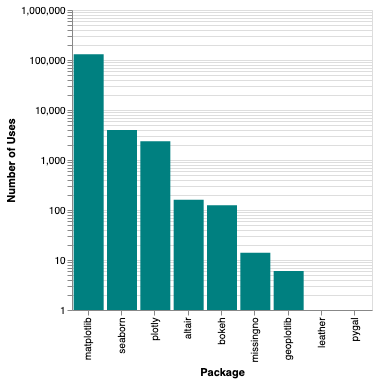

In [5]:
vis_counts = pd.Series([v.split('.')[0] for v in all_vis_uses if v.split('.')[0] != '']).value_counts().reset_index().rename(columns={'index':'Package',0:'Count'})
alt.Chart(vis_counts, width = 300).mark_bar(color='teal').encode(
    alt.X('Package',
         sort = alt.EncodingSortField(field="Count", op="sum",order="descending"),
    ),
    alt.Y('Count', title='Number of Uses', scale = alt.Scale(type='log'))
)

Matplotlib is by far the most popular visualization tool. It is over 100 times frequent than the next mot popular, which is seaborn.

# Uses By Package

In [6]:
def get_counts(package):
    return pd.Series(['.'.join(v.split('.')[1:]) for v in all_vis_uses 
               if v.startswith(package)
    ]).value_counts().reset_index().rename(columns={'index':'use', 0:'count'})

In [7]:
def chart_package(package):
    counts = get_counts(package)
    return alt.Chart(counts[:20], title='Use of {0}'.format(package.title()), height = 200, width = len(counts[:20])*30).mark_bar(color='teal').encode(
        alt.X('use',
              sort = alt.EncodingSortField(field="count", op="sum",order="descending"),
              title='Use'
        ),
        alt.Y('count', title = 'Number of Uses')
    )

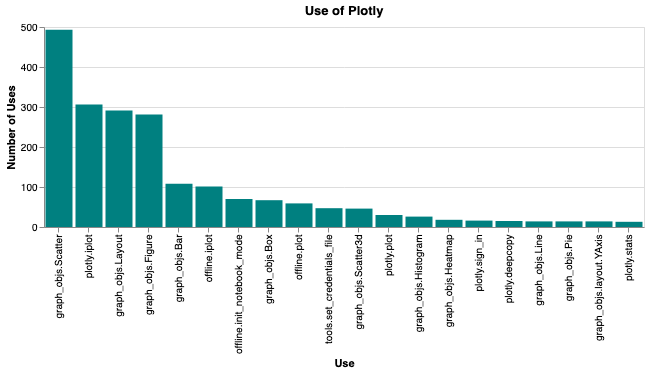

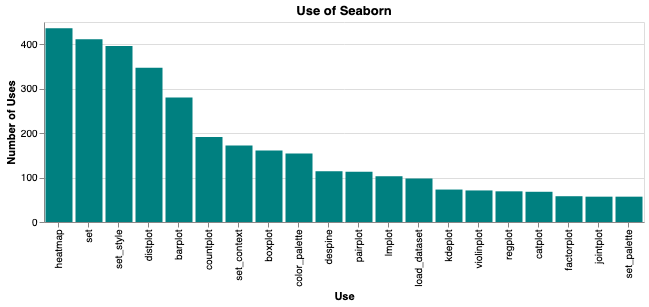

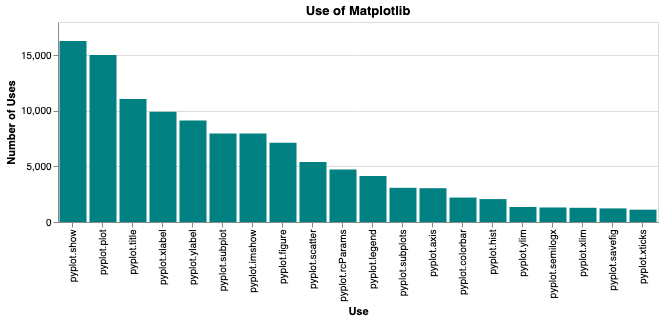

In [8]:
display(chart_package('plotly'))
display(chart_package('seaborn'))
display(chart_package('matplotlib'))

# MatPlotLib: what types of plots are people using?

In [9]:
plots = ['matplotlib.pyplot.plot',
         'matplotlib.pyplot.semilogx', #same as plot but with xscale = log
         'matplotlib.pyplot.semilogy', #same as plot but with yscale = log
         'matplotlib.pyplot.loglog',   #same as plot but with xscale = log, yscale = log
         'matplotlib.pyplot.scatter',
         'matplotlib.pyplot.hist',
         'matplotlib.pyplot.bar',
         'matplotlib.pyplot.colorbar',
         'matplotlib.pyplot.imshow',
         'matplotlib.pyplot.boxplot',
         'matplotlib.pyplot.step'
]

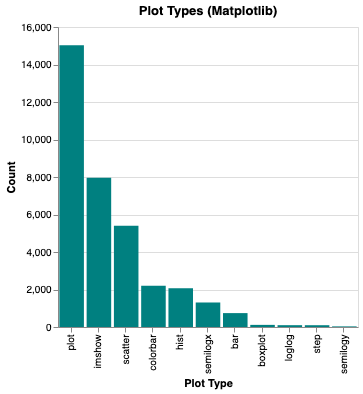

In [10]:
plot_counts = pd.Series([v.split('.')[-1] for v in all_vis_uses if v.startswith('matplotlib') and v in plots]).value_counts().reset_index().rename(columns={'index':'Plot Type', 0:'Count'})
alt.Chart(plot_counts, width = 300, title = 'Plot Types (Matplotlib)').mark_bar(color = 'teal').encode(
    alt.X('Plot Type',
         sort = alt.EncodingSortField(field="Count", op="sum",order="descending"),
    ),
    alt.Y('Count')
)

Plot (y vs x line plot) is by far the most popular plot type. Following that is imshow (displays an image or a colormap, depending on parameters) and scatter (y vs x scatter plot). About half as popular as imshow and scatter is hist (histogram of one variable). Other plotting methods are very unpopular.

# Popularities Over Time

In [11]:
DATE_CHOICE = 'pushed_at'

In [12]:
if DATE_CHOICE not in notebooks.columns:
    notebooks = notebooks.merge(repos[['repo_id',DATE_CHOICE]], on = 'repo_id')
notebooks[DATE_CHOICE] = pd.to_datetime(notebooks[DATE_CHOICE])
notebooks['year'] = [c.year for c in notebooks[DATE_CHOICE]]
notebooks['month'] = [c.month for c in notebooks[DATE_CHOICE]]

In [13]:
def get_vis_counts(v):
    return notebooks[[sum([(use[0]+'.'+use[1]).startswith(v) for use in uses]) > 0 
                      for uses in notebooks['vis']]].groupby(['year', 'month'])['file'].count().reset_index().rename(
                        columns = {'file':'count'}).merge(
        notebooks.groupby(['year','month'])['file'].count().reset_index().rename(
            columns = {'file': 'total_count'}
        ), 
        on = ['year','month']
    )

def plot_vis_counts(v, prop = False):
    df = get_vis_counts(v)
    df['order'] = [(row['year'], row['month']) for _, row in df.iterrows()]
    df.sort_values(by = 'order')
    df['time'] = range(len(df))
    df['prop'] = df['count'] / df['total_count']
    
    labels = [calendar.month_name[row['month']] +' '+ str(row['year']) for _, row in df.iterrows()]
    
    if prop:
        return alt.Chart(df[['time','prop']], title = '{0} Use over Time'.format(v.title())).mark_line(color='teal').encode(
            alt.X('time', title = 'Months since October 2013'),
            alt.Y('prop', title = 'Uses of {0}'.format(v.title()))
        )
    else:
        return alt.Chart(df[['time','count']], title = '{0} Use over Time'.format(v.title())).mark_line(color='teal').encode(
            alt.X('time', title = 'Months since October 2013'),
            alt.Y('count', title = 'Uses of {0}'.format(v.title()))
        )

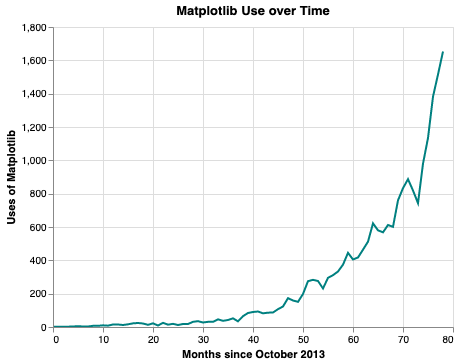

In [14]:
plot_vis_counts('matplotlib')

The growth of use of matplotlib matches the growth of Jupyter Notebooks.

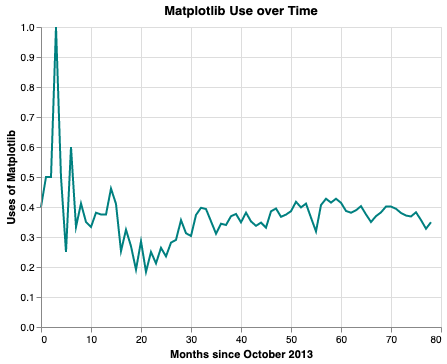

In [15]:
plot_vis_counts('matplotlib', prop = True)

The proportion of notebooks that use matplotlib had high variation in early months, likely due to the small number of notebooks, but looks to have converged to ~35% as the sample size has increased and variability has gone down.

# How many visualizations are typical in a notebook?

Plots are labeled in execute_result_keys as:
- 'application/vnd.vegalite.v2+json', 'application/vnd.vegalite.v3+json' - for altair plots
- 'image/png' - for matplotlib plots and seaborn plots

In [16]:
def count_vis_lists(list_of_lists):
    count = 0
    for li in list_of_lists:
        for l in li:
            if l in ['application/vnd.vegalite.v2+json', 'application/vnd.vegalite.v3+json', 'image/png']:
                count += 1
    return count

vis_by_file = cells.groupby('file')['execute_result_keys'].aggregate(count_vis_lists).reset_index().rename(columns = {'execute_result_keys':'num_vis'})

In [17]:
avg = vis_by_file.num_vis.mean()
print("On average, there are {0} visualizations per notebook.".format(round(avg,2)))

avg_within = vis_by_file[vis_by_file.num_vis > 0].num_vis.mean()
print("On average, among notebooks that have visualizations, there are {0} visualizations per notebook.".format(round(avg_within,2)))

num_0 = sum(vis_by_file.num_vis == 0)
print("\n{0} notebooks have no visualizations.".format(num_0))

num_1 = sum(vis_by_file.num_vis >= 1)
print("{0} notebooks have at least one visualization.".format(num_1))

num_10 = sum(vis_by_file.num_vis >= 10)
print("{0} notebooks have at least ten visualizations.".format(num_10))

On average, there are 0.01 visualizations per notebook.
On average, among notebooks that have visualizations, there are 2.95 visualizations per notebook.

58712 notebooks have no visualizations.
210 notebooks have at least one visualization.
12 notebooks have at least ten visualizations.


# How many visualizations are typical in a cell?
For this section, I focus exlusively on matplotlib visualizations.

In [18]:
def count_vis(li, imports):
    code = ' '.join(li)
    
    for im in imports:
        if len(im) == 2 and im[1] != '':
            code = code.replace(im[1], im[0])
            
    count = 0
    if 'matplotlib.pyplot.subplots' in code:
        count += code.count('matplotlib.pyplot.subplot(')
        code = code.replace('matplotlib.pyplot.subplot(', '')
    elif 'matplotlib.pyplot.show' in code:
        count += code.count('matplotlib.pyplot.show(')
        code = code.replace('matplotlib.pyplot.show(','')
    else:
        for p in plots:
            if p in code:
                count += code.count(p)
                code = code.replace(p,'')

    return count

In [19]:
def combine_lists(lists):
    li = []
    for l in lists:
        li += l
    return li

cells = cells.merge(
    cells.groupby('file')['imports'].aggregate(combine_lists).reset_index().rename(columns={'imports':'nb_imports'}),
    on = 'file'
)

In [20]:
vis_by_cell = pd.Series([count_vis(c.code, c.nb_imports) for _, c in cells.iterrows()])

In [21]:
avg = vis_by_cell.mean()
print("On average, there are {0} matplotlib visualizations per cell.".format(round(avg,2)))

avg_within = vis_by_cell[vis_by_cell > 0].mean()
print("On average, among cells that have matplotlib visualizations, there are {0} visualizations per cell.".format(round(avg_within,2)))

num_0 = sum(vis_by_cell == 0)
print("\n{0} cells have no matplotlib visualizations.".format(num_0))

num_1 = sum(vis_by_cell >= 1)
print("{0} cells have at least one matplotlib visualization.".format(num_1))

num_10 = sum(vis_by_cell >= 5)
print("{0} cells have at least five matplotlib visualizations.".format(num_10))

On average, there are 0.02 matplotlib visualizations per cell.
On average, among cells that have matplotlib visualizations, there are 1.2 visualizations per cell.

1505277 cells have no matplotlib visualizations.
24519 cells have at least one matplotlib visualization.
189 cells have at least five matplotlib visualizations.


<center> <a href = 5_Models.ipynb>ML Model Use &lt;</a> | <a href = 7_Time.ipynb>&gt; Time Spent</a> <center>